# Parkinson's Disease Classifier using Speech

*For full functionality please <a href="https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/6ulhmcbauyy7zlo/ParkinsonsDisease_SpeechClassifier_db.ipynb?dl=0" target="_blank">view this notebook in nbviewer</a>.*

After reading <a href="https://www.bbc.com/news/technology-50675702" target="_blank">an article</a> about using smartphones to diagnose Parkinson's disease, I have been intrigued with the AI realisation of medical technology. In this notebook, I will explore using speech attributes together with a K-Nearest Neighbor algorithm to identify if a person has Parkinson's disease. I will identify important features to build a model on, train it and evaluate its classifying performance.

#### About the data  
The data was collected as part of an academic effort to record speech attributes in participants with Parkinson's disease as well as healthy individuals. Information on the features and collection process can be found here:

Sakar, C.O., Serbes, G., Gunduz, A., Tunc, H.C., Nizam, H., Sakar, B.E., Tutuncu, M., Aydin, T., Isenkul, M.E. and Apaydin, H., 2018. A comparative analysis of speech signal processing algorithms for Parkinson's disease classification and the use of the tunable Q-factor wavelet transform. Applied Soft Computing, DOI: https://doi.org/10.1016/j.asoc.2018.10.022

The dataset is hosted on Kaggle and was <a href="https://www.kaggle.com/dipayanbiswas/parkinsons-disease-speech-signal-features" target="_blank">collected from here</a>. It includes data from 188 participants with Parkinon's disease as well as 64 individuals without the disease. 


### Table of Contents

* [Exploring Data](#chapter1)
    * [Choosing Feature Variables](#section_1_1)
    * [Correlation Matrix](#section_1_2)
    * [Feature Densities](#section_1_3)
* [K-Nearest Neighbors Model](#chapter2)
    * [Normalize Data](#section_2_1)
    * [Split Data](#section_2_2)
    * [Train Model](#section_2_3)
* [Model Evaluation](#chapter3)
    * [Model Validation](#section_3_1)
    * [Model Performance](#section_3_2)
* [Summary](#chapter4)

In [1]:
#displaying plots in notebook
%matplotlib inline

Here, we import the plotting libraries to use throughout the notebook.

In [2]:
#importing plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

## Exploring Data <a class="anchor" id="chapter1"></a>

Here, we read in the csv file of the speech attributes recorded by the group. It includes over 750 different features. Each participant was give an `id` number and their readings were taken three times. The last column called `class` shows if the participant has Parkinson's disease or whether they do not, with the following definitions:

- 0: no diagnosis of Parkinson's disease  
- 1: has been diagnosed with Parkinson's disease

Features were extracted using signal processing algorithms such as Mel Frequency Cepstral Coefficients (MFCCs) and the tunable Q-factor wavelet transform (TWQT). In total, 752 features were recorded and included in the dataset.


In [3]:
import pandas as pd

Parkinson_df_master = pd.read_csv('Data/pd_speech_features.csv')
Parkinson_df_master.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


### Choosing Feature Variables <a class="anchor" id="section_1_1"></a>

We are dealing with a lot of variables. However, not all will be useful for our purpose of identifying Parkinson's disease in an individual. Too many variables that are not useful can cloud our data with unwanted noise patterns and introduce *overtraining* effects. Furthermore, not all our variables correlate strongly with our outcome and the disadvantages of including them outweigh the benefits. So our next step is to look at the correlation between our outcome `class` and the individual features in the dataset. Using `Parkinson_df.corr().abs()`, we can get the correlation factor between each feature and our outcome `class`. This is very useful for us in limiting the variables to the most important ones. Here, I have selected all features that have a correlation factor of over 0.30, of which there are 50 of them. 

In [4]:
#select the feature variables and class columns
Parkinson_df = Parkinson_df_master.iloc[:,1:755]
col_class = Parkinson_df.pop('class')
Parkinson_df.insert(0, 'class', col_class)

#get correlation matrix as dataframe
corr_df = Parkinson_df.corr().abs().reset_index()
#selecting features with a high correlation factor
corr_best = corr_df[(corr_df['class'] > 0.30)] 
corr_best_list = corr_best['index'].tolist()[1:]

#separate features and label into different dataframes
Features_df = Parkinson_df[corr_best_list]
Labels_df = Parkinson_df['class']

### Correlation Matrix <a class="anchor" id="section_1_2"></a>

It is also useful to visualize the relationship between the outcome and features as a correlation matrix, as shown below. As expected, the diagonal elements have a correlation factor of 1.0, meaning the variable correlates exactly with itself. The closer the number is to zero, the less of a correlation there is. Two relationships are relevant for us here - how the features correlate with each other and how they correlate with the outcome. Features that correlate strongly with each other means they hold similar information and therefore, one of them can be dropped. Features with a high correlation factor with the outcome variable, however, means that they are important in predicting the outcome.

For example, looking at the matrix below of 10 features, we can see that `mean_MFCC_2nd_coef` and `std_6th_delta` have relatively high correlation factors with our outcome `class`. However, the correlation factor between them is only 0.07, very low. This means that not only do they hold relevant information for our outcome, but they both hold different information from each other.

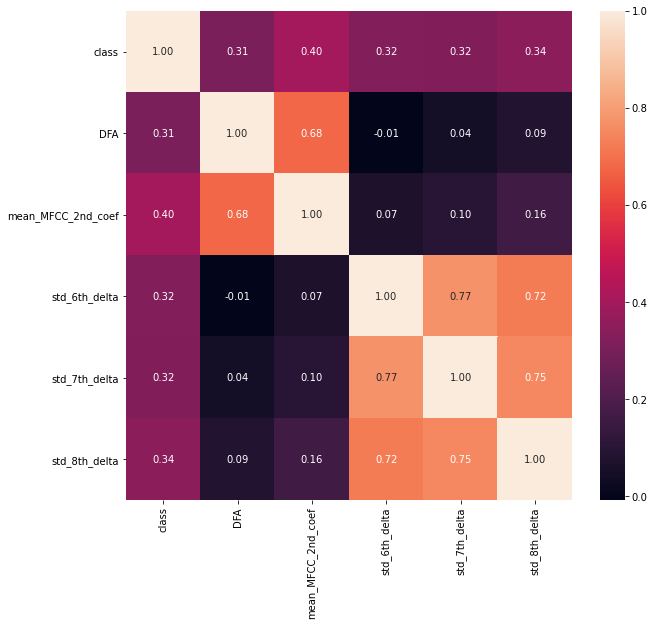

In [5]:
#plot correlation matrix to explore dependency between features
def plot_correlation(data):
    rcParams['figure.figsize'] = 10, 9
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()

Parkinson_df_best = Parkinson_df[corr_best['index'].tolist()[:6]]
plot_correlation(Parkinson_df_best)

### Feature Densities <a class="anchor" id="section_1_3"></a>

It is also useful to visualize the distribution of our features to see how much they differ for different outcomes. To do this, we will compare our features using density plots rather than histograms. Density plots are similar to histograms, except that the y-axis represents the probability density of a feature having a certain value, which is represented on the x-axis. The probability density is calculated using <a href="https://en.wikipedia.org/wiki/Kernel_density_estimation" target="_blank">kernel density estimation (KDE)</a>.  

The plots below show how four of the features vary in patients that have Parkinson's disease (`class` = 1) and in ones that don't (`class` = 0).  The larger the difference in the curves, the more useful it is for our model.

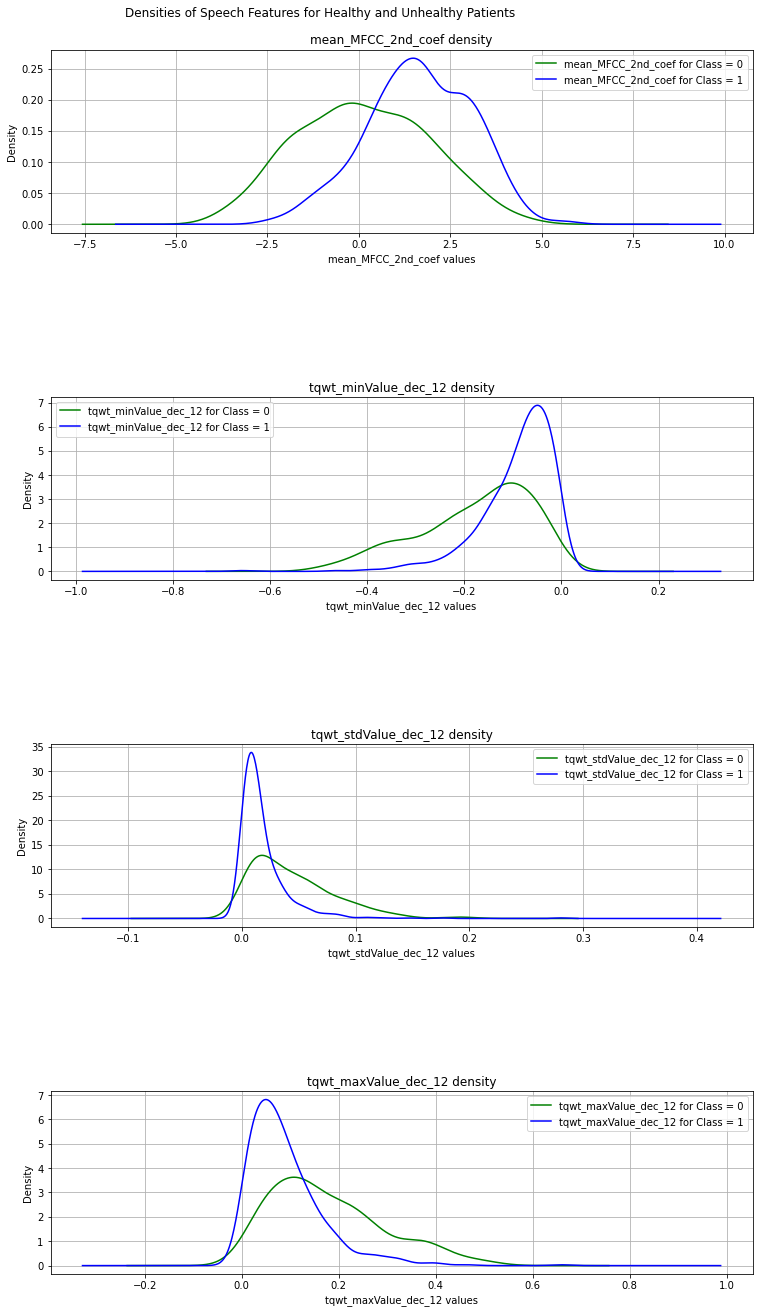

In [6]:
#Plot features densities depending on the outcome values
def plot_densities(data):
    rcParams['figure.figsize'] = 15, 20
    # create two dataframes based on class type
    class_0 = data[data['class'] == 0]
    class_1 = data[data['class'] == 1]

    # create figure
    col_names = list(data.columns)
    n_subplots = len(col_names[1:])
    fig, axs = plt.subplots(n_subplots, 1)
    fig.suptitle('Densities of Speech Features for Healthy and Unhealthy Patients')
    plt.subplots_adjust(left = 0.25, right = 0.9, bottom = 0.1, top = 0.95,
                        wspace = 0.2, hspace = 0.9)
    
    # plot density curves
    for col in col_names[1:]: 
        ax = axs[col_names.index(col)-1]
        class_0[col].plot(kind='density', ax=ax, subplots=True, 
                                    sharex=False, color="green", legend=True,
                                    label=col + ' for Class = 0')
        class_1[col].plot(kind='density', ax=ax, subplots=True, 
                                     sharex=False, color="blue", legend=True,
                                     label=col + ' for Class = 1')
        ax.set_xlabel(col + ' values')
        ax.set_title(col + ' density')
        ax.grid('on')
    plt.show()
    
# plot density curves
dens_best = corr_df.sort_values('class')
dens_list = dens_best['index'].tolist()[-5:]
dens_list = dens_list[::-1]
Parkinson_df_dens = Parkinson_df[dens_list]
plot_densities(Parkinson_df_dens)

## K-Nearest Neighbors Model <a class="anchor" id="chapter2"></a>

K-Nearest Neighbors (KNN) is a simple but powerful algorithm to determine which category a point belongs to. It does this by determining which points are 'similar' to itself. In this case, 'similar' is defined in terms of distance. We can visualise a 2-dimensional problem in the figure below, which shows two features (denoted by the axes) and an outcome (denoted by colour). When we train our model, we can think of it as having n-dimensions (n features), with each point representing an event. When we want to classify an unknown point, we find its feature values or coordinates. Once we know where it lies on this imaginary n-dimensional graph, we draw a circle around its neighbours to find which category it most likely belongs to. The integer number of neighbors we choose, K, can improve or decrease our accuracy. 

<img src="KNN.jpeg" alt="Drawing" width="400">

KNN Concept <a href="https://www.datacamp.com/" target="_blank">image credit</a>  

There are different ways to determine the distance from one point to its neighbour, such as Manhattan or Hamming distance, though the most popular choice is Euclidean distance:

$$ d(a,b) = \sqrt{   (a_{1} - b_{1})^2 + (a_{2} - b_{2})^2 + ... + (a_{n} - b_{n})^2   } $$

where *a* and *b* are two separate points and n represents the number of features. The algorithm calculates *d* from our unknown point to all points in the training dataset. Once it determines the closest neighbouring points, it finds the fraction of points belonging to either category and the unknown point is then assigned the category with the highest fraction. 

### Normalize Data <a class="anchor" id="section_2_1"></a>

In the rest of this section, we will go through the steps of building a KNN model based on the features we have selected in the previous section. The first step is to normalise the data. As the algorithm is based on a distance parameter and we are choosing neighbours based on an n-dimensional circle, we need to make sure all feature values are normalized. This is important so that one feature does not dominate over another. For this purpose, we will normalize our data based on min-max normalisation:

$$  \frac{x-min}{max-min}  $$

where *x* is the value we are trying to normalise. This is a popular way to normalize data and is what we will use in this notebook. However, outliers can cause issues with this method. In that case, using <a href="https://en.wikipedia.org/wiki/Standard_score" target="_blank">z-score normalisation</a> is safer. Below is the new feature dataframe with normalized values between 0 and 1.

In [7]:
from sklearn.preprocessing import MinMaxScaler

#Normalize Data
scaler = MinMaxScaler()
Features_array = scaler.fit_transform(Features_df)
Features_df = pd.DataFrame(Features_array)
Features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.565310,0.648846,0.100456,0.274790,0.198306,0.492469,0.329203,0.065993,0.190650,0.125508,...,0.935141,0.964164,0.958821,0.906152,0.054346,0.035836,0.041179,0.093055,0.000313,0.000576
1,0.489455,0.692990,0.319580,0.222088,0.108627,0.370569,0.243974,0.259510,0.161908,0.380722,...,0.825126,0.849494,0.903288,0.912409,0.196641,0.150506,0.096712,0.107328,0.000241,0.000594
2,0.428738,0.727579,0.364082,0.368946,0.261785,0.495129,0.266545,0.324765,0.499489,0.359732,...,0.952469,0.961191,0.966752,0.929719,0.032368,0.038809,0.033248,0.071476,0.000279,0.000557
3,0.819111,0.714858,0.171462,0.202469,0.265568,0.148387,0.274275,0.203987,0.179630,0.187372,...,0.695274,0.803427,0.765766,0.481933,0.270785,0.185898,0.238270,0.509617,0.001017,0.015906
4,0.822669,0.697982,0.109567,0.190275,0.256704,0.174108,0.209816,0.227780,0.119722,0.105506,...,0.804745,0.824852,0.802375,0.553449,0.210449,0.155455,0.205215,0.509392,0.001015,0.018467


### Split Data <a class="anchor" id="section_2_2"></a>

Here is where we split our dataset into training data and testing data. The training data will be used to tweak our model and tune the parameter *k*. It is important to keep the training and test sets separate. The test set should only be touched at the very end, when we want to find out how the model performs on a completely new and unbiased dataset. If we use it before, we might introduce overtraining effects in the final model as it learns the behaviour of our specific data sample and will not be able to generalise to new data. We will designate 20% of the data for testing and use the rest in the training phase.

In [8]:
from sklearn.model_selection import train_test_split

#TEST_TRAIN_SPLIT
train_datap, test_datap, train_labels, test_labels = train_test_split(Features_df, Labels_df, 
                                                                    test_size=0.2, random_state=1)

### Train Model <a class="anchor" id="section_2_3"></a>

In this section, I will go through the steps of the training phase. First, we create the classifier object using `KNeighborsClassifier(n_neighbors = k, weights='distance')` and fit the model with our training data using the `fit(X,y)` method. The `weights` can be specified as either 'uniform' (default) or 'distance' and is discussed further in [section 3.1](#section_3_1). 

As we want to find the *k* value that gives us the lowest validation error, we fit our training data for different values of *k* by looping through a range of odd values. It is a good idea to use odd values for *k* to prevent a tie. The `fit()` method is shown for reference only, as we use a k-fold cross validation method instead to find the accuracy of each *k* value.

#### Cross Validation

As mentioned above, we have split our data into training and testing data. We have used the training data to fit our model and the testing data we are only using at the end. So, what data do we use to tweak our model? With only these two datasets to work with, we need to use the training data to not only train a potential model, but also to tweak the model so that it has the best parameters. So, how do we do this?

With cross validation. Here, we will be using k-fold cross validation. This is when we divide the training data into smaller subsamples that allow us to check the outcome of the model. If using the training data for tuning our model, we would always get the correct answer when k=1 (its closest neighbour is itself) and it would be hard to find the best generalised model. When using cross validation, however, we can check the accuracy of a model by holding out a subset of the training data from the training phase and then using this subset as testing data. The scikit-learn library has a practical inbuilt method for this purpose called `cross_val_score()`. Here, I specify that I want to do a k-fold cross-validation with 10 subsamples (`cv`=10). The accuracy of the model for a specific *k* value is then averaged over those 10 tests. 

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

#Finding the best K
cv_scores_k = []
cv_scores = []
for k in range(1,81,2):
    KNN_classifier = KNeighborsClassifier(n_neighbors = k, weights='distance')
    #KNN_classifier.fit(train_datap, train_labels)

    scores = cross_val_score(KNN_classifier, train_datap, train_labels, cv=10, scoring='accuracy')
    cv_scores_k.append([scores.mean(), k])
    cv_scores.append(scores.mean())

#### Overfitting and Underfitting
The accuracy scores are converted to validation errors for ease of visualisation below. When *k* is one, the error is higher as we are overfitting the values. Essentially, our prediction boundaries aren't very smooth and we have a high variance in our prediction outcomes. As *k* increases, the model accuracy increases until the validation error reaches a minimum. As *k* gets larger, the opposite to overfitting occurs: underfitting. At high *k* values, we lose information and the smaller nuances of the data. 

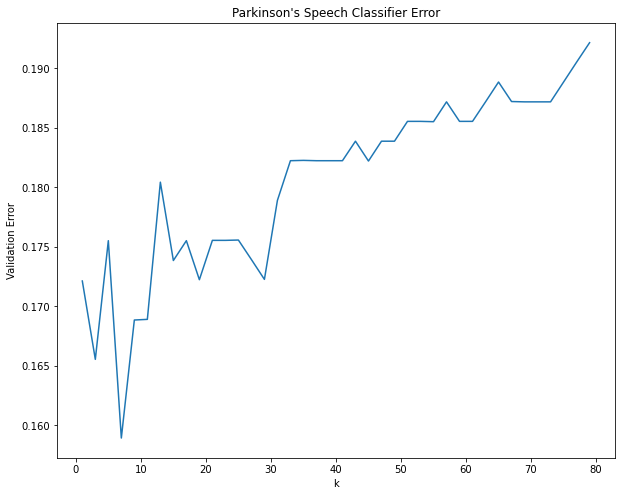

In [10]:
#converting from accuracy to validation error
missclass_error = [1 - x for x in cv_scores]

#plot missclassification error for different k values
rcParams['figure.figsize'] = 10, 8
plt.figure()
plt.plot(range(1,81,2), missclass_error)
plt.xlabel('k')
plt.ylabel('Validation Error')
plt.title('Parkinson\'s Speech Classifier Error')
plt.show()

#### Best K Value and Model

As we can see on the graph above and from the validation scores we found earlier, we find the lowest validation error at *k*=7. According to our k-fold cross validation, at *k*=7 we have a prediction accuracy of 84%. Finally, we retrain our model with the full training dataset and the *k* value we have determined to be the best. 

In [11]:
#store best k-value in variable
k_best = max(cv_scores_k)
print('Best K from Cross Validation: ', k_best)

#train model with best k value
KNN_classifier_best = KNeighborsClassifier(n_neighbors = k_best[-1])
KNN_classifier_best.fit(train_datap, train_labels) 

Best K from Cross Validation:  [0.8410655737704917, 7]


KNeighborsClassifier(n_neighbors=7)

## Model Evaluation <a class="anchor" id="chapter3"></a>

### Model Validation   <a class="anchor" id="section_3_1"></a>

We can do a sanity check here to see if we can trust the boundary calculations of the algorithm using just two features. Below, I have plotted the boundaries using our best *k* value, 7. Using these featrues, the boundaries look fine.

The two plots represent different weights: <a href="" target="_blank">uniform and distance</a>. The default option is 'uniform', where all neighbouring points are weighted equally. The option 'distance' weights the points based on the inverse of their distance, so closer neighbours are weighted more. The colours represent the areas on the plot where a point would either be classified as having Parkinson's disease (blue) or not (green). In our actual model, this is extended to 50 dimensions.

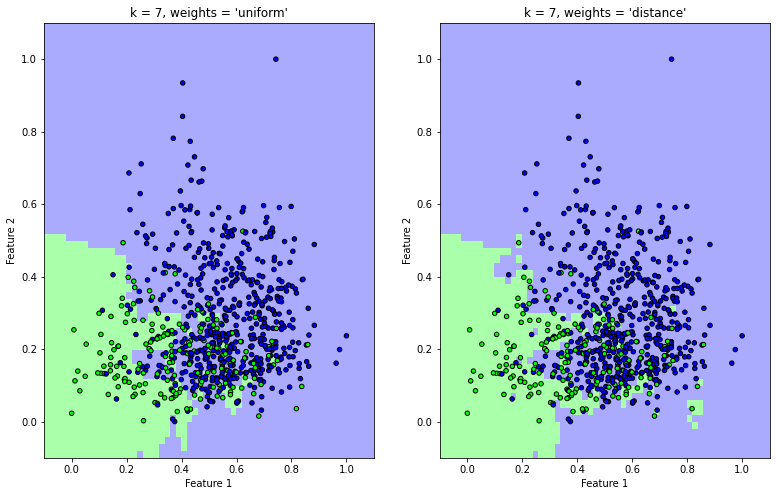

In [12]:
import numpy as np
from matplotlib.colors import ListedColormap

#Plotting example boundary for k with two features
def plot_boundaries(X, y):
    #Test, train and split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 35)

    #colour maps
    cmap_light = ListedColormap(['#AAFFAA', '#AAAAFF']) 
    cmap_bold  = ListedColormap(['#00FF00', '#0000FF']) 

    rcParams['figure.figsize'] = 13, 8
    n_neighbors = 7
    step_size   = .02  
    fig = plt.figure()
    i=1
    for weights in ['uniform', 'distance']:
        KNN_classifier = KNeighborsClassifier(n_neighbors, weights=weights)
        KNN_classifier.fit(X_train, y_train)

        # Assigning colour to each mesh area
        x_min, x_max = X[:, 0].min() -0.1, X[:, 0].max() +0.1
        y_min, y_max = X[:, 1].min() -0.1, X[:, 1].max() +0.1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size),
                             np.arange(y_min, y_max, step_size))
        Z = KNN_classifier.predict(np.c_[xx.ravel(), yy.ravel()])

        # Plot mesh
        Z = Z.reshape(xx.shape)
        plt.subplot(1,2,i)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

        # Plot feature points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)   
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title("k = %i, weights = '%s'" % (n_neighbors, weights))
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        i += 1

Features_array = np.array(Features_df.iloc[:, [1,2]])
Labels_df_ = Parkinson_df[['class']]
Labels_array = np.array(Labels_df_.iloc[:, 0])
plot_boundaries(Features_array, Labels_array)

### Model Performance <a class="anchor" id="section_3_2"></a>

#### Confusion Matrix

Now, we can use our test data to evaluate the accuracy of our final model. Up until now, we have not touched this data, as we want to evaluate it using an unseen and unbiased dataset. Below I have plotted the confusion matrix of how well our model has predicted the outcomes. Out of the 34 test points with outcome `class`=0 (no Parkinson's disease), 21 points were classified correctly while 13 were not. For the 118 test points with outcome `class`=1 (has Parkinson's disease), 109 were classified correctly and 9 were not.

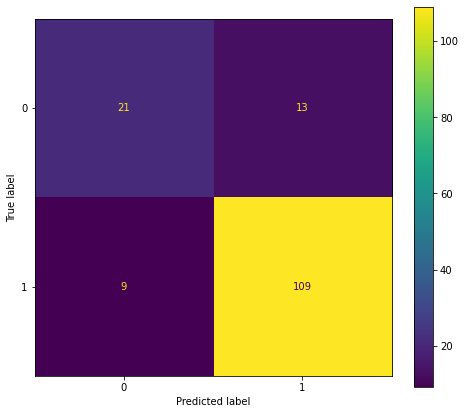

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

rcParams['figure.figsize'] = 8, 7
plot_confusion_matrix(KNN_classifier_best, test_datap, test_labels)

#### Model Accuracy

We can use the `score()` method to get the accuracy of the model, which is 85.5% as shown below.

In [14]:
score_test = KNN_classifier_best.score(test_datap, test_labels)
print('Model accuracy: {}'.format(score_test))

Model accuracy: 0.8552631578947368


To get a full report of the test results, we can call on `classification_report()` to print out the results. Below we can see the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html" target="_blank">precision, recall, f1-score and support</a> summarized together. 

- **precision**: the proportion of positive guesses that are in fact real positives (the columns of the confusion matrix above).
- **recall**: the proportion of true positives that were guessed correctly (the rows of the confusion matrix above).
- **f1-score**: the harmonic mean of precision (P) and recall (R) and is related by: $ f_{1} = 2 (\frac{P x R}{P + R}) $
- **support**: the total number of data points within each category of `class`=0 and `class`=1.
- **accuracy**: the proportion of data points that were classified correctly. 

As we can see from the report below, the recall is 92% for the outcome `class`=1. This means the model is very accurate at predicting when someone has Parkinson's disease, as there will be only 8% of false negatives in people with Parkinson's disease. On the other hand, in people who do not have the disease (`class`=0), 62% will be correctly classified as healthy. Although this is still much higher than 50%, there is still a high percentage (38%) of false positives in healthy individuals.  

The precision essentially states that we can trust 89% of positive results and 70% of negative results, if positive = 'has Parkinson's disease'. As discussed already, the model classified 86% of all test data correctly.

In [15]:
predict = KNN_classifier_best.predict(test_datap)
print(classification_report(test_labels,predict))

              precision    recall  f1-score   support

           0       0.70      0.62      0.66        34
           1       0.89      0.92      0.91       118

    accuracy                           0.86       152
   macro avg       0.80      0.77      0.78       152
weighted avg       0.85      0.86      0.85       152



## Summary <a class="anchor" id="chapter4"></a>

For this project, we have built a classifier to detect if a person has Parkinson's disease. The model classified 86% of cases correctly. It is more accurate for positive results - we can believe 89% of positive results and 70% of negative results. This was done by exploring over 750 possible features of voice recorded speech attributes, identifying features to build a model on, training it with a KNN approach and assessing its classifying accuracy. 

The model could be improved to find how accuracy changes based on stages of the disease, as treatment is more successful if a diagnosis is made in the early stages. Also, studying how the disease effects speech in different genders could improve accuracy. AI algorithms have the potential to quickly and accurately detect Parkinson's disease using a smartphone app, with <a href="https://www.sciencedirect.com/science/article/pii/S2173580818301974" target="_blank">first generation apps</a> now being rolled out. However,  The advantage of this KNN approach is the simplicity of the model, making it easier to develop. This also signals the ever more important role AI plays in medical technology, in diagnosing and treating people with a cheap, widely accessible solution.